<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Experiments/Weibo_image_only_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetV2 B3

In [1]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# image copy pipeline from Gdrive to Colab
! mkdir "/content/images"
! cp "/content/drive/MyDrive/multimodal-news/weibo-data/images.zip" "/content/images"
! unzip -q -d "/content/images" "/content/images/images.zip"

In [4]:

BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/weibo/'

## Load the dataframes

In [5]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(4140, 3) (1124, 3)


# Data input pipeline

In [6]:
def dataframe_to_dataset(dataframe):
    columns = ['image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [7]:
resize = (224, 224)

In [8]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [9]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  return {"image_1": image_1}

In [10]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [11]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [12]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [13]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [14]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

## ImageOnly model

In [15]:
def create_image_only_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
   # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    
    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    
    outputs = keras.layers.Dense(1, activation="sigmoid")(vision_projections)
    return keras.Model([image_1], outputs)

In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [17]:
image_only_model = create_image_only_model(attention=False, num_projection_layers=0, projection_dims=128, dropout_rate=0.0)
image_only_model.summary()

52606240/52606240 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              13127358  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13,127,487
Trainable params: 196,865
Non-trainable params: 12,930,622
_________________________________________________________________


### Model Training

In [18]:
epochs = 10
batch_size = 32

In [19]:
image_only_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = image_only_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 41s 153ms/step - loss: 0.5257 - accuracy: 0.7915 - precision: 0.2069 - recall: 0.0302 - val_loss: 0.5342 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
130/130 [==============================] - 14s 108ms/step - loss: 0.4959 - accuracy: 0.8077 - precision: 0.4667 - recall: 0.0088 - val_loss: 0.5272 - val_accuracy: 0.7678 - val_precision: 0.6667 - val_recall: 0.0076
Epoch 3/10
130/130 [==============================] - 14s 110ms/step - loss: 0.4924 - accuracy: 0.8087 - precision: 0.5517 - recall: 0.0201 - val_loss: 0.5331 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
130/130 [==============================] - 14s 111ms/step - loss: 0.4877 - accuracy: 0.8080 - precision: 0.5000 - recall: 0.0063 - val_loss: 0.5337 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
130/130 [==============================] - 15s 112ms/step

Plot training loss vs testing loss

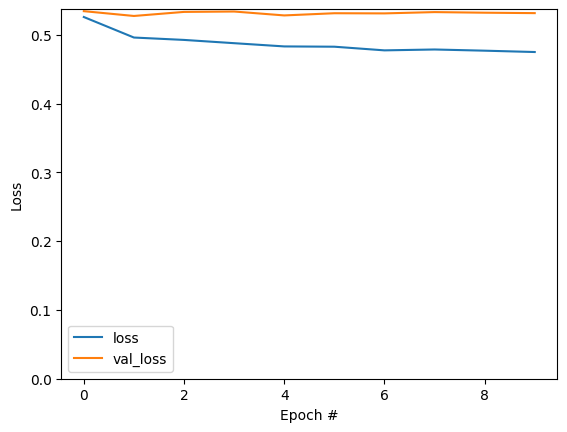

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

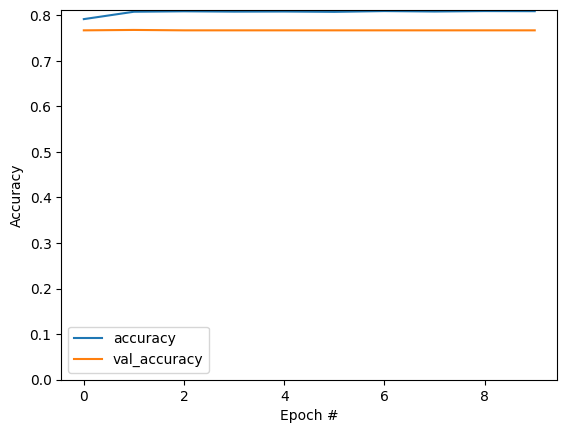

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [22]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [23]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [24]:
y_pred = image_only_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 5s 81ms/step
Accuracy == 0.7669039145907474
F1 == [0.86807654 0.        ]
Precision == [0.76690391 0.        ]
Recall == [1. 0.]


# InceptionNet

In [25]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.InceptionV3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = tf.keras.applications.inception_v3.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [26]:
image_only_model1 = create_image_only_model(attention=False, num_projection_layers=1, projection_dims=128, dropout_rate=0.0)
image_only_model1.summary()

87910968/87910968 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              22081824  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,081,953
Trainable params: 279,169
Non-trainable params: 21,802,784
_________________________________________________________________


### Model Training

In [27]:
image_only_model1.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history1 = image_only_model1.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 22s 114ms/step - loss: 0.5216 - accuracy: 0.7971 - precision: 0.2105 - recall: 0.0038 - val_loss: 0.5303 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
130/130 [==============================] - 11s 88ms/step - loss: 0.4584 - accuracy: 0.8092 - precision: 0.5490 - recall: 0.0352 - val_loss: 0.5288 - val_accuracy: 0.7598 - val_precision: 0.4429 - val_recall: 0.1183
Epoch 3/10
130/130 [==============================] - 11s 87ms/step - loss: 0.4327 - accuracy: 0.8140 - precision: 0.5668 - recall: 0.1333 - val_loss: 0.5305 - val_accuracy: 0.7411 - val_precision: 0.3876 - val_recall: 0.1908
Epoch 4/10
130/130 [==============================] - 11s 88ms/step - loss: 0.4048 - accuracy: 0.8285 - precision: 0.6491 - recall: 0.2327 - val_loss: 0.5381 - val_accuracy: 0.7456 - val_precision: 0.4178 - val_recall: 0.2328
Epoch 5/10
130/130 [==============================] - 11s 87ms/step - loss: 0.3766 - ac

Plot training loss vs testing loss

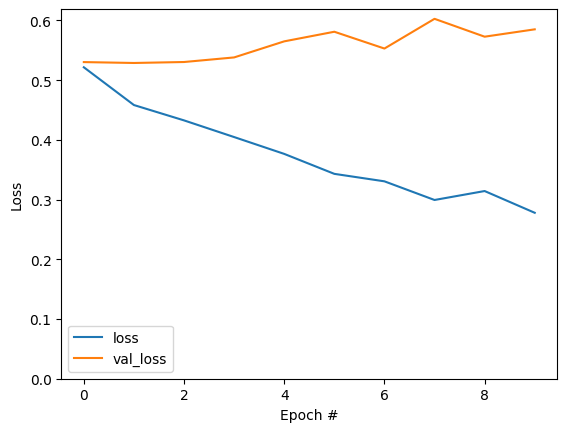

In [28]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

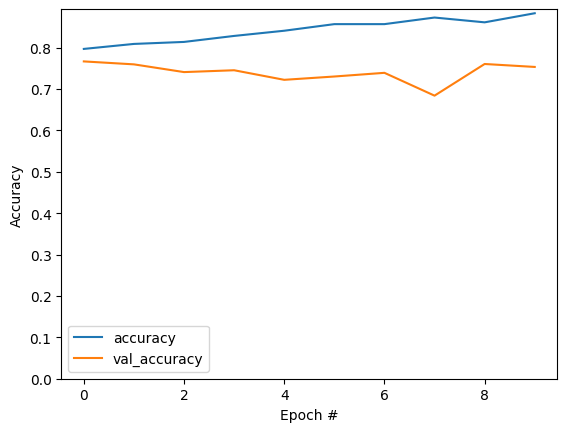

In [29]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [30]:
y_pred = image_only_model1.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 4s 66ms/step
Accuracy == 0.75355871886121
F1 == [0.85669943 0.12063492]
Precision == [0.77310924 0.35849057]
Recall == [0.96055684 0.07251908]


# MobileNetV3 Small

In [31]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.MobileNetV3Small(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = tf.keras.applications.mobilenet_v3.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [32]:
image_only_model2 = create_image_only_model(attention=False, num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
image_only_model2.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              1029744   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,029,873
Trainable params: 90,753
Non-trainable params: 939,120
_________________________________________________________________


### Model Training

In [33]:
image_only_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history2 = image_only_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 10s 43ms/step - loss: 0.4971 - accuracy: 0.7912 - precision: 0.3929 - recall: 0.0728 - val_loss: 0.5090 - val_accuracy: 0.7696 - val_precision: 0.6000 - val_recall: 0.0344
Epoch 2/10
130/130 [==============================] - 4s 29ms/step - loss: 0.4323 - accuracy: 0.8145 - precision: 0.5659 - recall: 0.1459 - val_loss: 0.5050 - val_accuracy: 0.7785 - val_precision: 0.6066 - val_recall: 0.1412
Epoch 3/10
130/130 [==============================] - 4s 28ms/step - loss: 0.4067 - accuracy: 0.8261 - precision: 0.6221 - recall: 0.2403 - val_loss: 0.5104 - val_accuracy: 0.7705 - val_precision: 0.5213 - val_recall: 0.1870
Epoch 4/10
130/130 [==============================] - 4s 28ms/step - loss: 0.3716 - accuracy: 0.8415 - precision: 0.6651 - recall: 0.3522 - val_loss: 0.5413 - val_accuracy: 0.7598 - val_precision: 0.4718 - val_recall: 0.2557
Epoch 5/10
130/130 [==============================] - 4s 29ms/step - loss: 0.3218 - accuracy: 0.861

Plot training loss vs testing loss

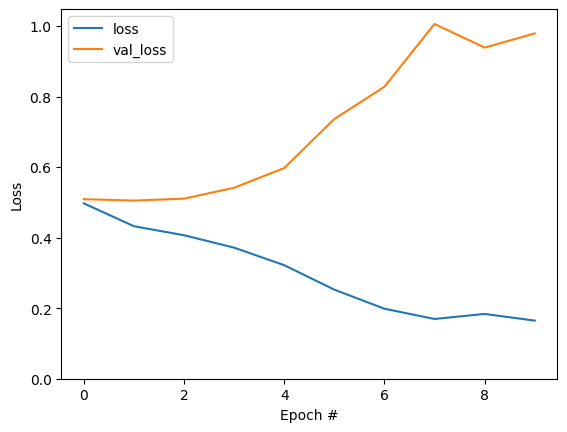

In [34]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

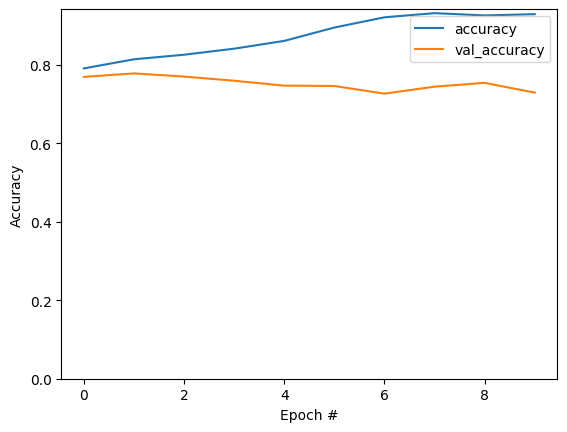

In [35]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [36]:
y_pred = image_only_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 2s 20ms/step
Accuracy == 0.7295373665480427
F1 == [0.82707622 0.37959184]
Precision == [0.81138393 0.40789474]
Recall == [0.84338747 0.35496183]


In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.DenseNet201(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = tf.keras.applications.densenet.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [ ]:
image_only_model3 = create_image_only_model(attention=False, num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
image_only_model3.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              18584640  
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 18,584,769
Trainable params: 262,785
Non-trainable params: 18,321,984
_________________________________________________________________


### Model Training

In [ ]:
image_only_model3.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history3 = image_only_model3.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 50s 249ms/step - loss: 0.4988 - accuracy: 0.7861 - precision: 0.3869 - recall: 0.1116 - val_loss: 0.5134 - val_accuracy: 0.7705 - val_precision: 0.8333 - val_recall: 0.0191
Epoch 2/10
130/130 [==============================] - 24s 188ms/step - loss: 0.4305 - accuracy: 0.8118 - precision: 0.5370 - recall: 0.1459 - val_loss: 0.5043 - val_accuracy: 0.7705 - val_precision: 0.5250 - val_recall: 0.1603
Epoch 3/10
130/130 [==============================] - 24s 185ms/step - loss: 0.3913 - accuracy: 0.8268 - precision: 0.6161 - recall: 0.2604 - val_loss: 0.5273 - val_accuracy: 0.7616 - val_precision: 0.4741 - val_recall: 0.2099
Epoch 4/10
130/130 [==============================] - 24s 185ms/step - loss: 0.3439 - accuracy: 0.8481 - precision: 0.6758 - recall: 0.4013 - val_loss: 0.6272 - val_accuracy: 0.7705 - val_precision: 0.5169 - val_recall: 0.2328
Epoch 5/10
130/130 [==============================] - 24s 187ms/step - loss: 0.3048 - accura

Plot training loss vs testing loss

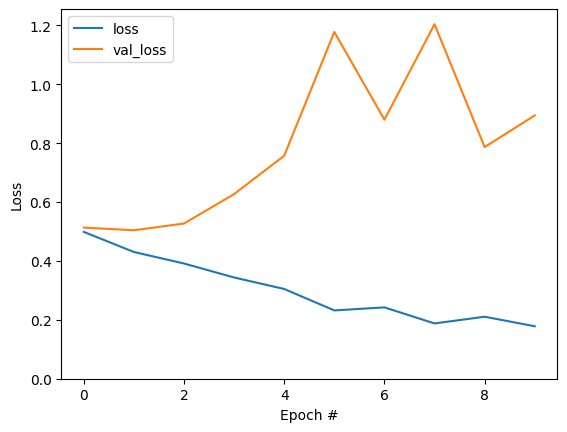

In [ ]:
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

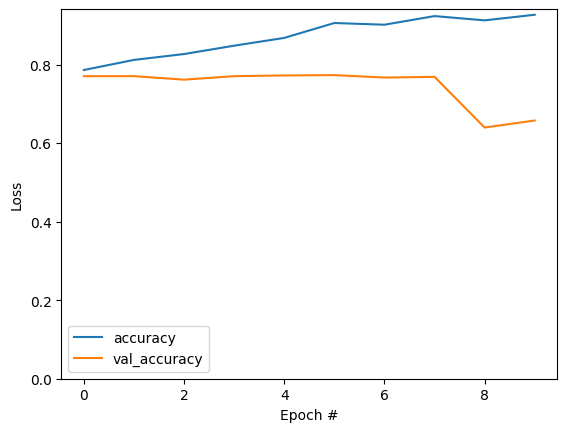

In [ ]:
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
y_pred = image_only_model3.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 9s 139ms/step
Accuracy == 0.6574733096085409
F1 == [0.75493316 0.43131462]
Precision == [0.83638928 0.35180723]
Recall == [0.68793503 0.55725191]
